In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_moons, make_circles, make_blobs
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
seed = 20181122
samples = 500
is_liner = 0 # 0.linear(default), 1.moons, 2.circles
features = 2
if is_liner == 0:
#     data, label = make_classification(n_features=features,
#                                       n_clusters_per_class=1, 
#                                       n_samples=samples,
#                                       n_informative=features,
#                                       n_redundant=0,
#                                       n_repeated=0,
#                                       n_classes=2)
    data, label = make_blobs(n_samples=samples, n_features=features, centers=2, random_state=seed)
elif is_liner == 1:
    data, label = make_moons(n_samples=samples, noise=0.1, random_state=seed) # 月牙形状数据集
elif is_liner == 2:
    data, label = make_circles(n_samples=samples, noise=0.1, factor=0.4, random_state=seed) # 圆形数据集
label = label.reshape((len(label), 1))

In [2]:
# data = np.hstack([data, (data[:, 0] - data[:, 1]).reshape((data.shape[0], 1))])
# data = np.hstack([data, (data[:, 0] + data[:, 1]).reshape((data.shape[0], 1))])
# data = np.hstack([data, (data[:, 0] * data[:, 1]).reshape((data.shape[0], 1))])
# data = np.hstack([data, np.power(data[:, 0], 2).reshape((data.shape[0], 1))])
# data = np.hstack([data, np.power(data[:, 1], 2).reshape((data.shape[0], 1))])

In [3]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

In [4]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 2), (100, 2), (400, 1), (100, 1))

In [5]:
train = pd.DataFrame(X_train, columns=[f'f{i}' for i in range(features)])
train['label'] = y_train

test = pd.DataFrame(X_test, columns=[f'f{i}' for i in range(features)])
test['label'] = y_test

In [6]:
def plot_graph(df, title=""):
    t = df.query('label == 0')
    x, y = t['f0'].values, t['f1'].values
    plt.scatter(x, y)
    t = df.query('label == 1')
    x, y = t['f0'].values, t['f1'].values
    plt.scatter(x, y)
    plt.legend(['0', '1'])
    plt.title(title)
    plt.show()

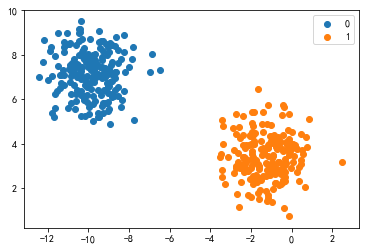

In [7]:
plot_graph(train)

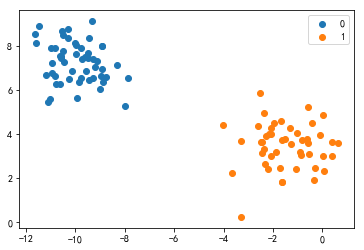

In [8]:
plot_graph(test)

In [9]:
all_data = pd.DataFrame(data, columns=[f'f{i}' for i in range(features)])
all_data['label'] = label

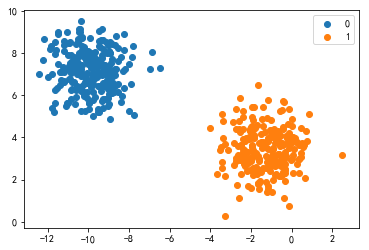

In [10]:
plot_graph(all_data)

In [11]:
# 计算训练集合上的均值 最大值 最小值 用来归一化
mean = np.mean(X_train, axis=0)
maxium = np.max(X_train, axis=0)
minium = np.min(X_train, axis=0)

# 归一化
def normalizition(X, maxium=maxium, minium=minium, mean=mean):
    return (X - mean) / (maxium - minium)

X_train = normalizition(X_train)
X_test = normalizition(X_test)

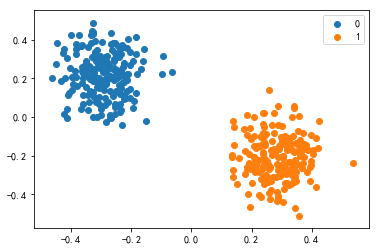

In [12]:
# 下面绘制归一化后的数据集情况
t = pd.DataFrame(X_train, columns=[f'f{i}' for i in range(features)])
t['label'] = y_train
plot_graph(t)

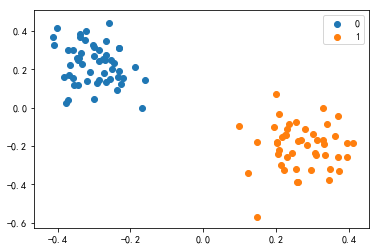

In [13]:
t = pd.DataFrame(X_test, columns=[f'f{i}' for i in range(features)])
t['label'] = y_test
plot_graph(t)

In [14]:
# activation func:sigmoid
def sigmoid(x):
    return 1 / (1+np.exp(-x))
# sigmoid 导数
def sigmoid_prime(x):
    return x * (1 - x)

# activation func:relu
def relu(x):
    return np.maximum(x, 0)
# relu 导数
def relu_prime(z):
    z[z>0]=1
    return z

# activation func: swish
# google提出的一个激活函数，据说比relu好
def swish(x):
    return x * sigmoid(x)
# swish 导数
def swish_prime(x):
    return swish(x) + sigmoid(x) * (1 - swish(x))

# loss function
def binary_crossentropy(label, pred_y):
    return np.mean(-label * np.log(pred_y) - (1 - label) * np.log(1 - pred_y))

# metric
def accuracy(label, pred_y):
    return np.mean(label == (pred_y > 0.5).astype(np.int))

# 激活
def activation(x, acti=sigmoid):
    return acti(x)

# predict
def predict(X, model):
    l1_out = activation(np.dot(X, w0), activati)
    l2_out = activation(np.dot(l1_out, w1), activati)
    pred_y = sigmoid(np.dot(l2_out, w2))
    return pred_y

In [15]:
# 绘制决策边界
def plot_decision_boundary(pred_func, X, y):
 
    # 设定最大最小值，附加一点点边缘填充
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
 
    # 用预测函数预测一下
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
 
    # 然后画出图
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y.reshape((len(y), )), cmap=plt.cm.Spectral)


In [16]:
# best model
best_model = {"w0":None, 
              "w1":None, 
              "w2":None}
# 早停轮次
stop_epoch = np.inf #30
early_stopping = {"epoch":stop_epoch,
                  "current_epoch":0}
# 最佳得分
best_score = -np.inf
# 最佳epoch
best_epoch = 1
# 迭代次数
epoch = 300
# 存储loss
cost_train = []
cost_test = []
# metric
train_metric = []
val_metric = []
# 学习率 : 可以更改一下放大或者缩小10倍，看看下面的loss图的变化
alpha = 0.001
# 如果要设置激活函数 请改下面两行代码
# 设置激活函数
activati = relu
# 激活函数的导数
prime = relu_prime
# 初始化权重
np.random.seed(seed=seed)
w0 = np.random.normal(size=(X_train.shape[1], 2))
w1 = np.random.normal(size=(2, 2))
w2 = np.random.normal(size=(2, 1))
for i in range(epoch):
    # 正向传播
    l1_out = activation(np.dot(X_train, w0), activati)
    l2_out = activation(np.dot(l1_out, w1), activati)
    pred_y = sigmoid(np.dot(l2_out, w2))
    # 反向传播
#     pred_err = (y_train - pred_y) * (pred_y * (1 - pred_y))
#     l2_to_l1_err = pred_err.dot(w2.T) * (l2_out * (1 - l2_out))
#     l1_to_input_err = l2_to_l1_err.dot(w1.T) * (l1_out * (1 - l1_out))
    pred_err = (y_train - pred_y) * sigmoid_prime(pred_y)# * (1 - pred_y))
    l2_to_l1_err = pred_err.dot(w2.T) * prime(l2_out)
    l1_to_input_err = l2_to_l1_err.dot(w1.T) * prime(l1_out)
    # 根据误差更新权重
    w2 += alpha * l2_out.T.dot(pred_err)
    w1 += alpha * l1_out.T.dot(l2_to_l1_err)
    w0 += alpha * X_train.T.dot(l1_to_input_err)
    model = {"w0":w0, "w1":w1, "w2":w2}
    # 训练集的loss
    cost_train.append(binary_crossentropy(y_train, pred_y))
    test_y = predict(X_test, model)
    cost_test.append(binary_crossentropy(y_test, test_y))
    # 训练集metric
    train_metric.append(accuracy(label=y_train, pred_y=pred_y))
    # 测试集 metric
    score = accuracy(label=y_test, pred_y=test_y)
    val_metric.append(score)
    if score > best_score:
        best_score = score
        best_epoch = i
        best_model['w0'] = w0
        best_model['w1'] = w1
        best_model['w2'] = w2
        early_stopping = {"epoch":stop_epoch,
                          "current_epoch":0}
    
    if early_stopping["epoch"] == early_stopping["current_epoch"]:
        break
    early_stopping["current_epoch"] += 1
#         pass
#     if i % 30 == 0:
    print(f'epoch:{i + 1}',
          'train cost:', cost_train[-1],
          'test cost:', cost_test[-1],
          'train acc:', train_metric[-1], 
          'test acc:', val_metric[-1])    

epoch:1 train cost: 0.692395002617 test cost: 0.691404288351 train acc: 0.5075 test acc: 0.47
epoch:2 train cost: 0.690434350395 test cost: 0.68939157755 train acc: 0.5075 test acc: 0.47
epoch:3 train cost: 0.68844846729 test cost: 0.687351707024 train acc: 0.5075 test acc: 0.47
epoch:4 train cost: 0.686428238962 test cost: 0.685275997394 train acc: 0.5075 test acc: 1.0
epoch:5 train cost: 0.684364776418 test cost: 0.683155987286 train acc: 1.0 test acc: 1.0
epoch:6 train cost: 0.68224941289 test cost: 0.680983429805 train acc: 1.0 test acc: 1.0
epoch:7 train cost: 0.68007370307 test cost: 0.678750291216 train acc: 1.0 test acc: 1.0
epoch:8 train cost: 0.677829424543 test cost: 0.676448751674 train acc: 1.0 test acc: 1.0
epoch:9 train cost: 0.675508581275 test cost: 0.674071207878 train acc: 1.0 test acc: 1.0
epoch:10 train cost: 0.673103409034 test cost: 0.671610277556 train acc: 1.0 test acc: 1.0
epoch:11 train cost: 0.670606382637 test cost: 0.669058805678 train acc: 1.0 test acc: 1

epoch:95 train cost: 0.202420322546 test cost: 0.204348326903 train acc: 1.0 test acc: 1.0
epoch:96 train cost: 0.199214670303 test cost: 0.201182466129 train acc: 1.0 test acc: 1.0
epoch:97 train cost: 0.19609719738 test cost: 0.198103346247 train acc: 1.0 test acc: 1.0
epoch:98 train cost: 0.193065176761 test cost: 0.195108268187 train acc: 1.0 test acc: 1.0
epoch:99 train cost: 0.190115934816 test cost: 0.192194588273 train acc: 1.0 test acc: 1.0
epoch:100 train cost: 0.187246855537 test cost: 0.189359722109 train acc: 1.0 test acc: 1.0
epoch:101 train cost: 0.184455383924 test cost: 0.186601147615 train acc: 1.0 test acc: 1.0
epoch:102 train cost: 0.181739028605 test cost: 0.183916407358 train acc: 1.0 test acc: 1.0
epoch:103 train cost: 0.179095363781 test cost: 0.181303110219 train acc: 1.0 test acc: 1.0
epoch:104 train cost: 0.176522030586 test cost: 0.178758932507 train acc: 1.0 test acc: 1.0
epoch:105 train cost: 0.174016737919 test cost: 0.17628161858 train acc: 1.0 test acc:

epoch:184 train cost: 0.0824373635467 test cost: 0.0852079938814 train acc: 1.0 test acc: 1.0
epoch:185 train cost: 0.0819145716285 test cost: 0.0846835008192 train acc: 1.0 test acc: 1.0
epoch:186 train cost: 0.0813990323927 test cost: 0.0841662085582 train acc: 1.0 test acc: 1.0
epoch:187 train cost: 0.0808905961008 test cost: 0.0836559694352 train acc: 1.0 test acc: 1.0
epoch:188 train cost: 0.0803891170314 test cost: 0.0831526397298 train acc: 1.0 test acc: 1.0
epoch:189 train cost: 0.0798944533502 test cost: 0.0826560795366 train acc: 1.0 test acc: 1.0
epoch:190 train cost: 0.0794064669843 test cost: 0.0821661526427 train acc: 1.0 test acc: 1.0
epoch:191 train cost: 0.0789250235013 test cost: 0.0816827264095 train acc: 1.0 test acc: 1.0
epoch:192 train cost: 0.0784499919935 test cost: 0.0812056716588 train acc: 1.0 test acc: 1.0
epoch:193 train cost: 0.0779812449652 test cost: 0.0807348625632 train acc: 1.0 test acc: 1.0
epoch:194 train cost: 0.0775186582255 test cost: 0.080270176

epoch:275 train cost: 0.0531911001209 test cost: 0.0557293597439 train acc: 1.0 test acc: 1.0
epoch:276 train cost: 0.0529951058145 test cost: 0.055530708783 train acc: 1.0 test acc: 1.0
epoch:277 train cost: 0.0528007511942 test cost: 0.0553337027128 train acc: 1.0 test acc: 1.0
epoch:278 train cost: 0.0526080152728 test cost: 0.0551383206243 train acc: 1.0 test acc: 1.0
epoch:279 train cost: 0.0524168774209 test cost: 0.0549445419632 train acc: 1.0 test acc: 1.0
epoch:280 train cost: 0.0522273173595 test cost: 0.0547523465222 train acc: 1.0 test acc: 1.0
epoch:281 train cost: 0.0520393151524 test cost: 0.0545617144342 train acc: 1.0 test acc: 1.0
epoch:282 train cost: 0.0518528511994 test cost: 0.0543726261647 train acc: 1.0 test acc: 1.0
epoch:283 train cost: 0.0516679062287 test cost: 0.054185062505 train acc: 1.0 test acc: 1.0
epoch:284 train cost: 0.0514844612905 test cost: 0.0539990045658 train acc: 1.0 test acc: 1.0
epoch:285 train cost: 0.0513024977503 test cost: 0.05381443377

In [17]:
f"best_epoch:{best_epoch}, best_score:{best_score}"

'best_epoch:3, best_score:1.0'

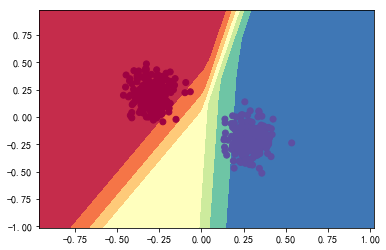

In [18]:
# 绘制训练集合的决策边界
# if features == 2:
plot_decision_boundary(pred_func=lambda x : predict(x, best_model), X=X_train, y=y_train)
plt.show()

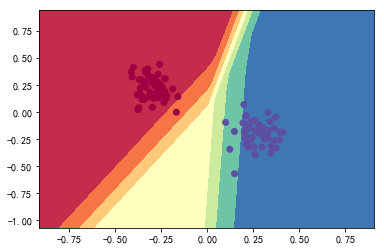

In [19]:
# 绘制测试集的决策边界
# if features == 2:
plot_decision_boundary(pred_func=lambda x : predict(x, best_model), X=X_test, y=y_test)
plt.show()

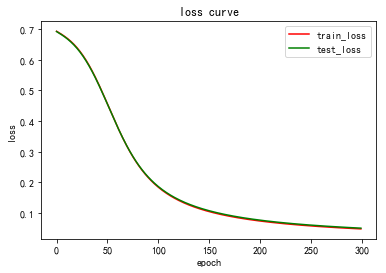

In [20]:
# loss曲线
plt.plot(list(range(len(cost_train))), cost_train, color='r')
plt.plot(list(range(len(cost_test))), cost_test, color='g')
plt.legend(['train_loss', 'test_loss'])
plt.title('loss curve')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

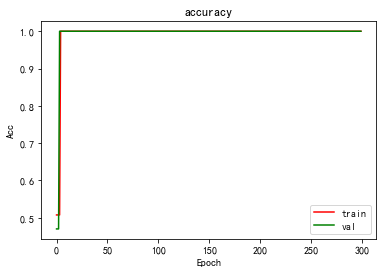

In [21]:
# metric 曲线
plt.plot(list(range(len(train_metric))), train_metric, color='r')
plt.plot(list(range(len(val_metric))), val_metric, color='g')
plt.legend(['train', 'val'])
plt.title('accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.show()

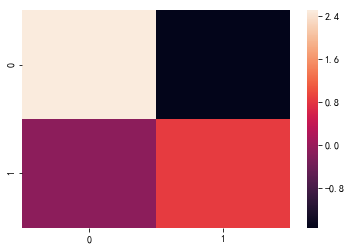

In [22]:
# w0权重
sns.heatmap(best_model['w0'])
plt.show()

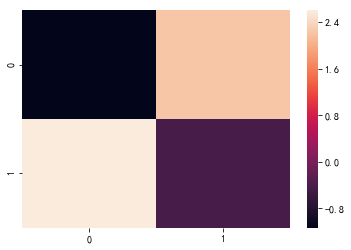

In [23]:
# w1 权重
sns.heatmap(best_model['w1'])
plt.show()

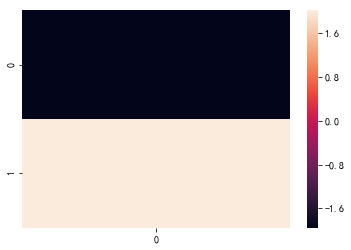

In [24]:
# w2权重
sns.heatmap(best_model['w2'])
plt.show()

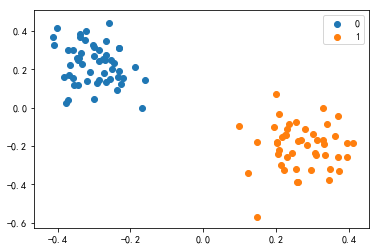

In [25]:
test = pd.DataFrame(X_test, columns=['f0', 'f1'])
test['label'] = y_test
plot_graph(test)

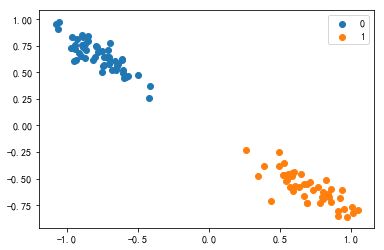

In [26]:
test_w0 = pd.DataFrame(test[['f0', 'f1']].values.dot(best_model['w0']), columns=['f0', 'f1'])
test_w0['label'] = y_test
plot_graph(test_w0)

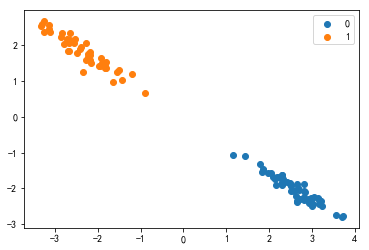

In [27]:
test_w1 = pd.DataFrame(test_w0[['f0', 'f1']].values.dot(best_model['w1']), columns=['f0', 'f1'])
test_w1['label'] = y_test
plot_graph(test_w1)

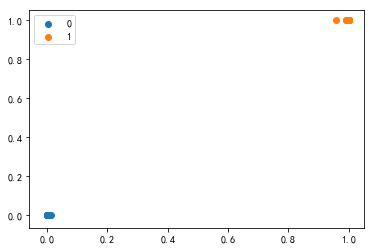

In [28]:
test_w2 = pd.DataFrame(sigmoid(test_w1[['f0', 'f1']].values.dot(best_model['w2'])), columns=['f0'])
test_w2['f1'] = y_test
test_w2['label'] = y_test
plot_graph(test_w2)